In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pymc3 as pm

In [4]:
import pystan

# Load Data 

In [5]:
markets = pd.read_csv('data/markets.csv')
markets['date'] = pd.to_datetime(markets.iloc[:, 0])

In [6]:
markets.set_index('date', inplace=True)

In [7]:
gspc = markets[markets.index >= '1980-01-01'].iloc[:, 1].dropna()

In [8]:
# log return
r = gspc.apply(np.log).diff().dropna()

In [9]:
# residual from ARIMA(1,0,0)
# eps = (r + 0.0265 * r.shift(1)).dropna()
eps = (r + 0.0277 * r.shift(1) + 0.0425 * r.shift(2)).dropna()

In [10]:
eps = eps - eps.mean()

In [12]:
stats.describe(eps)

DescribeResult(nobs=9318, minmax=(-0.23182359038164266, 0.10552581164650085), mean=-1.7872231561898849e-20, variance=0.00012494393026803077, skewness=-1.2587173008999715, kurtosis=27.06196436861634)

# Stochastic Volatility Model

In [10]:
with pm.Model() as sp500_model:
    beta = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.Exponential('sigma', lam=2)
    
    log_variance_intercept = pm.Exponential('log_variance_intercept', lam=.3)

    log_variance = pm.AR1('log_variance', beta, sigma**-2, shape=len(eps))
    tau = pm.Deterministic('variance_process',
                           255 * pm.math.exp(- (- log_variance_intercept + log_variance)))

    residual = pm.Normal('residual', 0, tau=tau, observed=eps)

In [11]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [14:23<00:00,  2.89it/s]


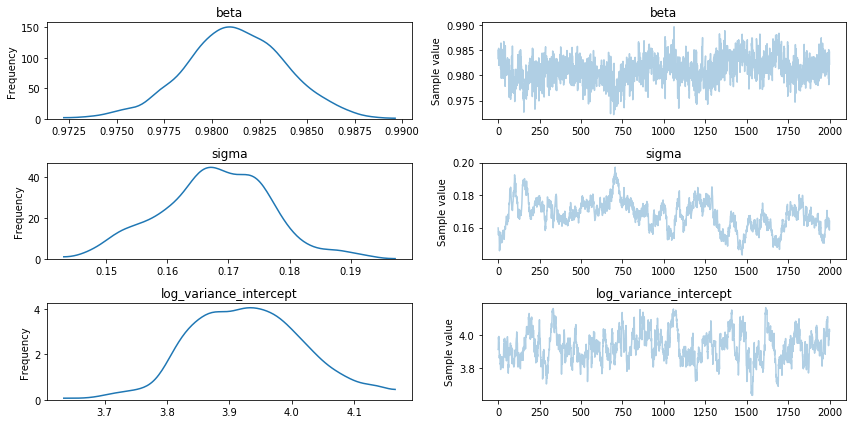

In [12]:
pm.traceplot(trace, [beta, sigma, log_variance_intercept]);

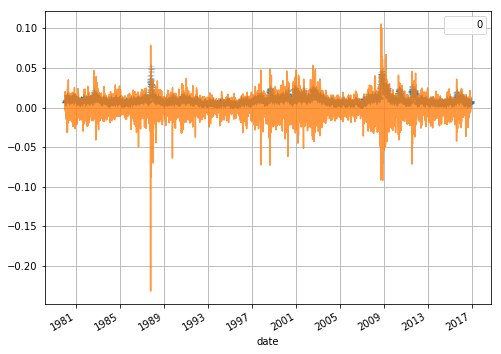

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
est_var = pd.DataFrame(np.sqrt(1 / trace['variance_process', ::5000]).T,
                       index=eps.index[-9319:])
est_var.plot(alpha=.3, style='+', ax=ax)
eps.iloc[-9319:].plot(ax=ax, alpha=.8)
plt.grid()

In [17]:
(np.median(trace['beta']), np.median(trace['sigma']),
 np.median(trace['log_variance_intercept']))

(0.98118313757652564, 0.16801614012939231, 3.9263072369436443)

# Regime-Switching Model

In [44]:
rsmodelspec = """
data {
    int<lower=0> J;
    real eps[J];
}
parameters {
    real<lower = 0, upper = 1> p0;
    real<lower = 0, upper = 1> p11;
    real<lower = 0, upper = 1> p21;
    real mu[2];
    positive_ordered[2] sigma;
}
transformed parameters {
    real p[J]; 
    p[1] = p0;
    for (j in 2:J)
        p[j] = p11 * p[j - 1] + p21 * (1 - p[j - 1]);
}
model {
    p0 ~ beta(.7, .3);
    p11 ~ beta(.8, .2);
    p21 ~ beta(.5, .5);
    
    mu[1] ~ normal(0, 1);
    mu[2] ~ normal(0, 1);
    sigma[1] ~ inv_gamma(1, .1);
    sigma[2] ~ inv_gamma(1, .5);
    
    for (j in 1:J) {
        target += log_sum_exp(log(p[j]) + normal_lpdf(eps[j] | mu[1], sqrt(sigma[1] / 255)),
            log(1 - p[j]) + normal_lpdf(eps[j] | mu[2], sqrt(sigma[2] / 255)));
    }
}
"""

In [45]:
rsmodel = pystan.StanModel(model_code=rsmodelspec)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6c60ec69eaa966b79659849933606bfd NOW.


In file included from /var/folders/n5/b1q77_bj2sg7j8yxm_jn2y080000gn/T/tmpjt99tdm9/stanfit4anon_model_6c60ec69eaa966b79659849933606bfd_6829895904124083624.cpp:599:
In file included from /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1809:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/n5/b1q77_bj2sg7j8yxm_jn2y080000gn/T/tmpjt99tdm9/stanfit4anon_model

In [14]:
eps[:5]

date
1980-01-07    0.002490
1980-01-08    0.020083
1980-01-09    0.001231
1980-01-10    0.008190
1980-01-11    0.000173
Name: YAHOO/INDEX_GSPC - Close, dtype: float64

In [57]:
len(eps['2008'])

253

In [46]:
rsmodel_data = {'J': len(eps['2006':'2010']), 'eps': eps['2006':'2010']}

In [47]:
fit = rsmodel.sampling(data=rsmodel_data, iter=2000, chains=4)

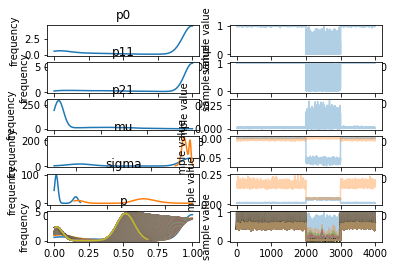

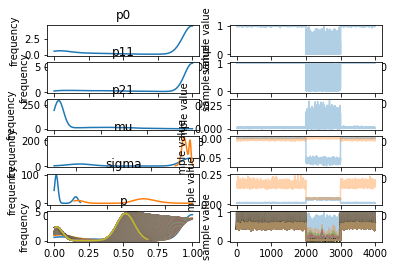

In [48]:
fit.plot()

In [49]:
print(fit)

Inference for Stan model: anon_model_6c60ec69eaa966b79659849933606bfd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p0         0.81    0.25   0.35 4.8e-3   0.95    1.0    1.0    1.0      2   2.89
p11        0.86    0.17   0.29   0.05    1.0    1.0    1.0    1.0      3   1.93
p21      3.3e-3  2.9e-3 5.1e-3 8.9e-5 8.0e-4 1.1e-3 1.7e-3   0.02      3   1.64
mu[0]     -0.01    0.02   0.03  -0.06  -0.03 6.2e-4 8.7e-4 1.3e-3      2  12.77
mu[1]   -1.7e-3  1.0e-3 1.8e-3-4.9e-3-3.1e-3-1.9e-3 8.5e-5 1.2e-3      3   1.59
sigma[0]   0.02    0.01   0.01 9.0e-3   0.01   0.01   0.02   0.05      2   7.53
sigma[1]   0.14    0.04   0.05   0.05   0.09   0.16   0.17    0.2      2    3.8
p[0]       0.81    0.25   0.35 4.8e-3   0.95    1.0    1.0    1.0      2   2.89
p[1]       0.77    0.28    0.4 8.7e-3   0.73    1.0    1.0    1.0      2   8.79
p[2]       

In [50]:
res = fit.extract()

In [31]:
for key in res:
    print(key, res[key].shape)

p0 (4000,)
p11 (4000,)
p21 (4000,)
mu (4000, 2)
sigma (4000, 2)
p (4000, 1259)
lp__ (4000,)


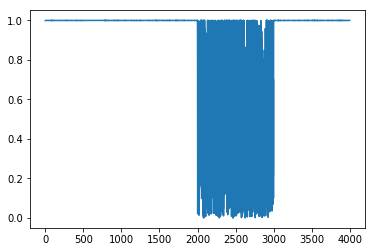

In [51]:
plt.plot(res['p11'])

{'boxes': [<matplotlib.lines.Line2D at 0x14669def0>,
 'caps': [<matplotlib.lines.Line2D at 0x14668ba58>,
 'fliers': [<matplotlib.lines.Line2D at 0x1466997b8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x146699358>,
 'whiskers': [<matplotlib.lines.Line2D at 0x14668b0b8>,
  <matplotlib.lines.Line2D at 0x1464e0b38>]}

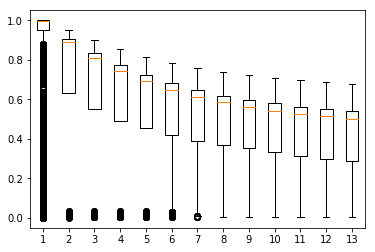

In [60]:
plt.boxplot(res['p'][:, ::100])